<center><h2><b> Image Enhancement Using GCN

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D
from sklearn.model_selection import train_test_split

# Load images
images_lr = []
images_hr = []
for i in range(0, 100):
    image_lr = io.imread(f"LR/{i}.png")
    image_hr = io.imread(f"HR/{i}.png")
    image_lr_resized = resize(image_lr, (96, 96), anti_aliasing=True)
    image_hr_resized = resize(image_hr, (384, 384), anti_aliasing=True)
    images_lr.append(color.rgb2gray(image_lr_resized))
    images_hr.append(color.rgb2gray(image_hr_resized))

# Split data into training and testing sets
X_train_lr, X_test_lr, X_train_hr, X_test_hr = train_test_split(images_lr, images_hr, test_size=0.2, random_state=42)

# Define super-resolution model
def SRGNC(input_shape):
    # Define input layer
    input_layer = Input(shape=input_shape)

    # Define GCN layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Define upsampling layer
    output_layer = UpSampling2D(size=(4, 4))(output_layer)

    # Define model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define loss function
def srgcn_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile model
model = SRGNC(input_shape=(96, 96, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=srgcn_loss)

# Preprocess data
X_train_lr = np.array(X_train_lr).reshape(-1, 96, 96, 1)
X_test_lr = np.array(X_test_lr).reshape(-1, 96, 96, 1)
X_train_hr = np.array(X_train_hr).reshape(-1, 384, 384, 1)
X_test_hr = np.array(X_test_hr).reshape(-1, 384, 384, 1)

## Train the model

In [3]:
# Train model for super-resolution 
history = model.fit(X_train_lr, X_train_hr, batch_size=32, epochs=1000, validation_data=(X_test_lr, X_test_hr))

# Save model
model.save("srgnc_model.h5")

## Load the pre trained model (h5) file

In [4]:
# Load model
model = tf.keras.models.load_model("srgnc_model.h5", custom_objects={'srgcn_loss': srgcn_loss})

## Plotting the enhanced images

In [5]:
import os
# Create directory for enhanced images
if not os.path.exists("Enhanced HR"):
    os.mkdir("Enhanced HR")

1/1 [==============================] - 0s 160ms/step


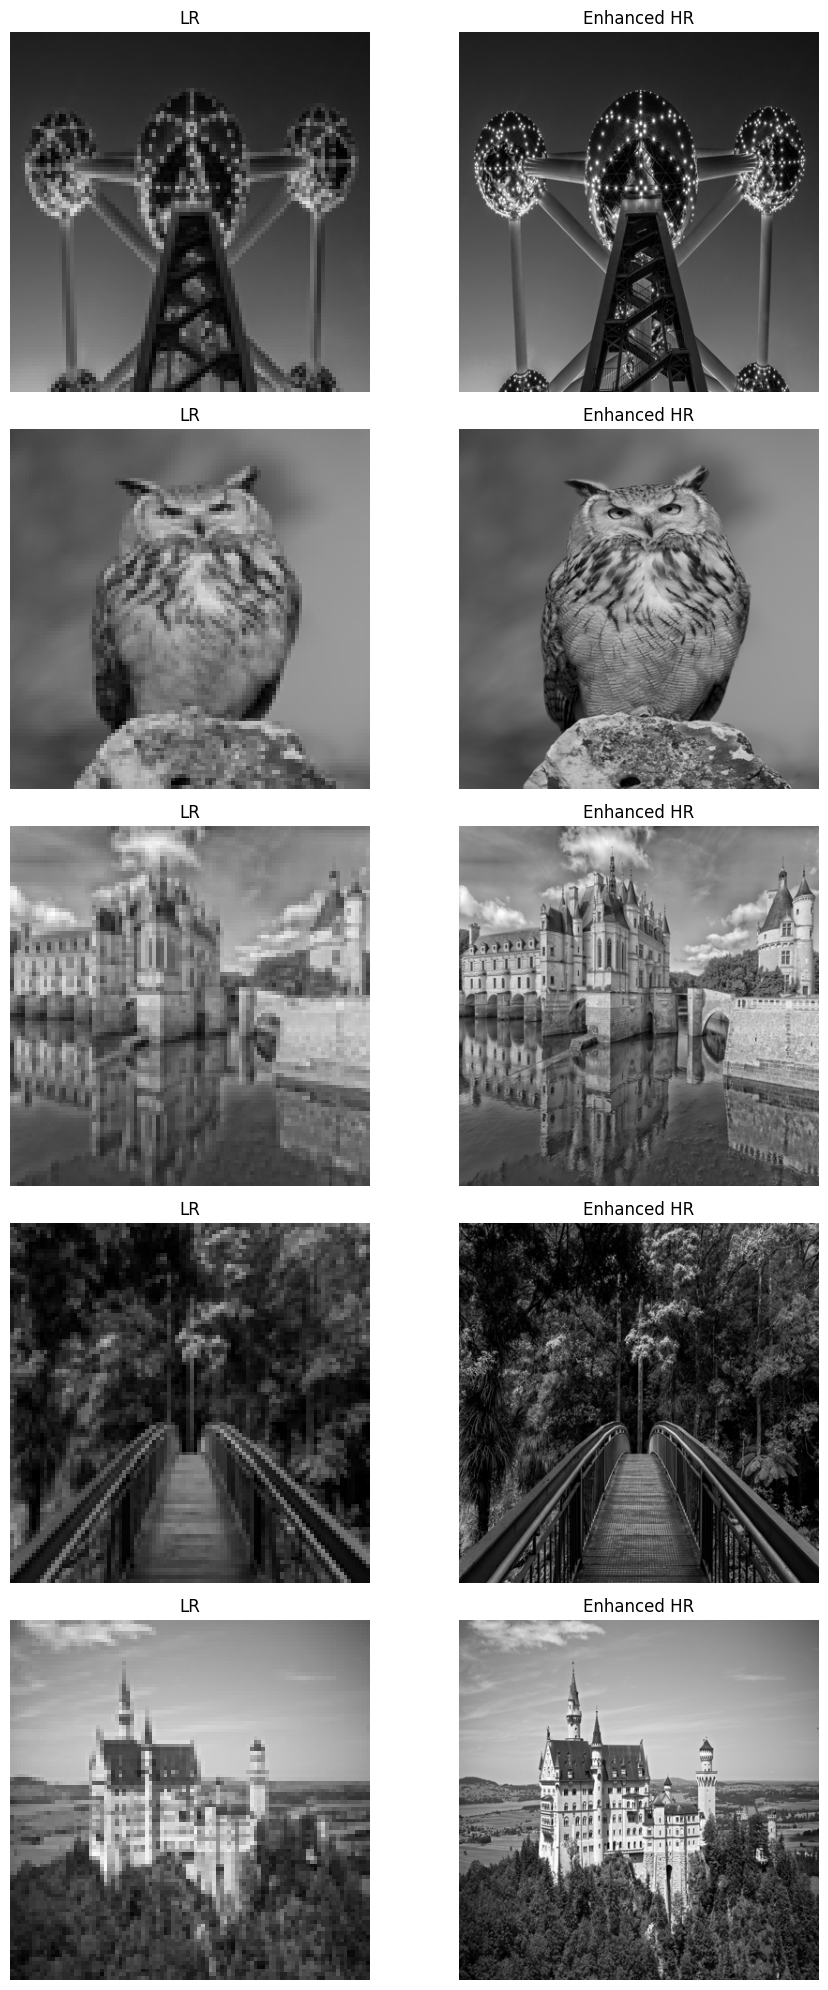

In [6]:
import imageio
# Plot original and enhanced images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(1, 6):
    # Load LR and HR images
    lr_image = io.imread(f"Test LR/{i}.png")
    lr_image = resize(lr_image, (96, 96), anti_aliasing=True)
    lr_image = color.rgb2gray(lr_image)
    lr_image = np.array(lr_image).reshape(1, 96, 96, 1)

    # Generate enhanced HR image
    enhanced_image = model.predict(lr_image)
    enhanced_image = enhanced_image.reshape(384, 384)
         
    # Save enhanced HR image
    enhanced_image = (enhanced_image * 255).astype(np.uint8)
    enhanced_image_rgb = color.gray2rgb(enhanced_image)
    enhanced_image_rgb = Image.fromarray(enhanced_image_rgb)
    imageio.imwrite(f"Enhanced HR/{i}_Enhanced.png", enhanced_image_rgb)

      
    # Plot original LR and HR and enhanced HR images side by side
    axs[i-1, 0].imshow(color.gray2rgb(lr_image[0,:,:,0]))
    axs[i-1, 0].set_title('LR')
    axs[i-1, 0].axis('off')

    axs[i-1, 1].imshow(color.gray2rgb(enhanced_image))
    axs[i-1, 1].set_title('Enhanced HR')
    axs[i-1, 1].axis('off')

plt.tight_layout()
plt.show()